# Pose Estimation across Object Using Nerf and DINO

## Import Everything

In [1]:
import torch
import numpy as np
import open3d as o3d
import torch.nn.functional as F
import torch.nn as nn
from pytorch3d.transforms import rotation_6d_to_matrix, matrix_to_rotation_6d
import math
import os
import gc
import cv2
import re
import matplotlib.pylab as plt
import json
from pyhocon import ConfigFactory
from typing import Union
import warnings
import torchvision.transforms as T
import tqdm

from models.fields import RenderingNetwork, SDFNetwork, SingleVarianceNetwork, NeRF, FeatureNetwork, FeatureField
from models.renderer import NeuSRenderer, MeanRenderer, select_vertices_and_update_triangles
from reconstruct.optimizer import Optimizer
from reconstruct.utils import color_table, set_view, get_configs

# from models.features.clip_extract import CLIPArgs, extract_clip_features
from models.features.dino_extract import DINOArgs, extract_dino_features
from models.features.pca_colormap import apply_pca_colormap
from models.dataset_mvdiff import expand_features
from models.utils import Lie

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def split_underscore(input_str):
    # split the input string into the last part and the rest by underscore
    end = input_str.split('_')[-1]
    rest = '_'.join(input_str.split('_')[:-1])
    return rest, end


def load_checkpoint(case_name, checkpoint_fname):
    # read network config
    conf_path = './confs/wmask_ar.conf'
    f = open(conf_path)
    conf_text = f.read()
    conf_text = conf_text.replace('CASE_NAME', case_name) 
    f.close()
    conf = ConfigFactory.parse_string(conf_text)
    anneal_end = conf.get_float('train.anneal_end', default=0.0)

    # load feature field
    checkpoint = torch.load(os.path.join(checkpoint_fname), map_location='cuda')

    nerf_outside = NeRF(**conf['model.nerf']).to(device)
    sdf_network = SDFNetwork(**conf['model.sdf_network']).to(device)
    deviation_network = SingleVarianceNetwork(**conf['model.variance_network']).to(device)
    color_network = RenderingNetwork(**conf['model.rendering_network']).to(device)
    feature_network = FeatureField(**conf['model.feature_field']).to(device)
    feature_render = MeanRenderer()

    nerf_outside.load_state_dict(checkpoint['nerf'])
    sdf_network.load_state_dict(checkpoint['sdf_network_fine'])
    deviation_network.load_state_dict(checkpoint['variance_network_fine'])
    color_network.load_state_dict(checkpoint['color_network_fine'])
    feature_network.load_state_dict(checkpoint['feature_network'])
    renderer = NeuSRenderer(
        nerf_outside, sdf_network, deviation_network, color_network, feature_network, feature_render,**conf['model.neus_renderer']
    )

    print(f"loaded checkpoint from {checkpoint_fname}")
    return renderer, anneal_end


def Rx_random():
    theta = np.random.uniform(-np.pi/3, np.pi/3)
    return torch.tensor([
        [1, 0, 0, 0],
        [0, np.cos(theta), -np.sin(theta), 0],
        [0, np.sin(theta), np.cos(theta), 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32)


def RT_opengl2opencv(RT):
    """convert between opengl and opencv coordinate convention"""
    R = RT[:3, :3]
    t = RT[:3, 3]

    R_bcam2cv = np.asarray([[1, 0, 0], [0, -1, 0], [0, 0, -1]], np.float32)

    R_world2cv = R_bcam2cv @ R
    t_world2cv = R_bcam2cv @ t

    RT = np.concatenate([R_world2cv,t_world2cv[:,None]],1)

    return RT


def unproj_map(width, height, f, c=None, device="cpu"):
    """
    Get camera unprojection map for given image size.
    [y,x] of output tensor will contain unit vector of camera ray of that pixel.
    :param width image width
    :param height image height
    :param f focal length, either a number or tensor [fx, fy]
    :param c principal point, optional, either None or tensor [fx, fy]
    if not specified uses center of image
    :return unproj map (height, width, 3)
    """
    if c is None:
        c = [width * 0.5, height * 0.5]
    else:
        c = c.squeeze()
    if isinstance(f, float):
        f = [f, f]
    elif len(f.shape) == 0:
        f = f[None].expand(2)
    elif len(f.shape) == 1:
        f = f.expand(2)
    Y, X = torch.meshgrid(
        torch.arange(height, dtype=torch.float32) - float(c[1]),
        torch.arange(width, dtype=torch.float32) - float(c[0]),
    )
    X = X.to(device=device) / float(f[0])
    Y = Y.to(device=device) / float(f[1])
    Z = torch.ones_like(X)
    unproj = torch.stack((X, -Y, -Z), dim=-1)
    unproj /= torch.norm(unproj, dim=-1).unsqueeze(-1)
    return unproj

#TODO understand this function
def get_cos_anneal_ratio(iter_step):
    if anneal_end == 0.0:
        return 1.0
    else:
        return np.min([1.0, iter_step / anneal_end])


def gen_rays(poses, width, height, focal, z_near, z_far, c=None, ndc=False):
    """
    Generate camera rays
    :return (B, H, width, 8)
    ndc: Normalized Device Coordinates
    """
    num_images = poses.shape[0]
    device = poses.device
    cam_unproj_map = (
        unproj_map(width, height, focal.squeeze(), c=c, device=device)
        .unsqueeze(0)
        .repeat(num_images, 1, 1, 1)
    )
    cam_centers = poses[:, None, None, :3, 3].expand(-1, height, width, -1)
    cam_raydir = torch.matmul(
        poses[:, None, None, :3, :3], cam_unproj_map.unsqueeze(-1)
    )[:, :, :, :, 0]

    if ndc:
        if not (z_near == 0 and z_far == 1):
            warnings.warn(
                "dataset z near and z_far not compatible with NDC, setting them to 0, 1 NOW"
            )
        z_near, z_far = 0.0, 1.0
        cam_centers, cam_raydir = ndc_rays(
            width, height, focal, 1.0, cam_centers, cam_raydir
        )

    cam_nears = (
        torch.tensor(z_near, device=device)
        .view(1, 1, 1, 1)
        .expand(num_images, height, width, -1)
    )
    cam_fars = (
        torch.tensor(z_far, device=device)
        .view(1, 1, 1, 1)
        .expand(num_images, height, width, -1)
    )
    return torch.cat(
        (cam_centers, cam_raydir, cam_nears, cam_fars), dim=-1
    )  # (B, H, W, 8)


def gen_rays_from_a_view(poses, width, height, resolution_level=1):
    """
    poses: (B, 3, 4)    
    Generate rays at world space from one camera.
    """
    tx = torch.linspace(0, width, width)
    ty = torch.linspace(0, height, height)
    pixels_x, pixels_y = torch.meshgrid(tx, ty)
    pixels_x = pixels_x.reshape(-1).float()
    pixels_y = pixels_y.reshape(-1).float()

    q = torch.stack([(pixels_x/width-0.5)*2, (pixels_y/height-0.5)*2, torch.zeros_like(pixels_y)], dim=-1) # WxH, 3
    v = torch.stack([torch.zeros_like(pixels_y), torch.zeros_like(pixels_y), torch.ones_like(pixels_y)], dim=-1) # WxH, 3

    # orthogonal projection
    rays_v = v / torch.linalg.norm(v, ord=2, dim=-1, keepdim=True)  # WxH, 3 
    # print(rays_v.shape)
    if len(poses.shape) == 2: # (3,4) to (1,3,4)
        poses = poses.unsqueeze(0)
    rays_v = torch.matmul(poses[:, :3, :3].cuda(), rays_v[None, :, :].transpose(1,2).cuda())
    rays_v = rays_v.transpose(1,2) # B, WxH, 3
    
    rays_o = torch.matmul(poses[:,:3, :3].cuda(), q[None, :, :].transpose(1,2).cuda())  #B, 3, WxH 
    rays_o = rays_o.transpose(1,2) # B, WxH, 3
    rays_o = poses[:, :3, 3].unsqueeze(1).expand(rays_v.shape).cuda() + rays_o   # batch_size, 3
    rays = torch.cat([rays_o, rays_v], dim=-1)    # batch_size, 6
    return rays


def inv_RT(RT):
    RT_h = np.concatenate([RT, np.array([[0,0,0,1]])], axis=0)
    RT_inv = np.linalg.inv(RT_h)

    return RT_inv[:3, :]


def rgb2bgr(img_rgb):
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    return img_bgr


def show_img(title, img_rgb):  # img - rgb image
    # img_bgr = rgb2bgr(img_rgb)
    cv2.imshow(title, img_rgb)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def find_POI(img_rgb, DEBUG=False): # img - RGB image in range 0...255
    # generate dense keypoints
    img = np.copy(img_rgb)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints = sift.detect(img_gray, None)
    if DEBUG:
        img = cv2.drawKeypoints(img_gray, keypoints, img)
        show_img("Detected points", img)
    xy = [keypoint.pt for keypoint in keypoints]
    xy = np.array(xy).astype(int)
    # Remove duplicate points
    xy_set = set(tuple(point) for point in xy)
    xy = np.array([list(point) for point in xy_set]).astype(int)
    return xy # pixel coordinates


# 1d 2d convert
def flatten_position(row, col, width):
    return row * width + col


def unflatten_position(index, width):
    row = index // width
    col = index % width
    return row, col


def visualize_sampling_area(img, roi):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for point in roi:
        cv2.circle(img, (point[0], point[1]), 1, (0, 0, 255), -1)
    show_img("ROI", img)


def generate_SE3_noise(cam_pose, amplitude=0.1):
    """
    Generate SE3 noise for camera pose
    """
    se3_noise = torch.randn(cam_pose.shape[0],6,device=cam_pose.device)*amplitude
    SE3_noise = Lie().se3_to_SE3(se3_noise)
    SE3_noise = torch.cat([SE3_noise, torch.tensor([[[0, 0, 0, 1]]], device=SE3_noise.device).repeat(SE3_noise.shape[0], 1, 1)], dim=1)
    return SE3_noise


def compose_pair(pose_a,pose_b):
    # pose_new(x) = pose_b o pose_a(x)
    R_a,t_a = pose_a[...,:3,:3],pose_a[...,:3,3:]
    R_b,t_b = pose_b[...,:3,:3],pose_b[...,:3,3:]
    R_new = R_b@R_a
    t_new = (R_b@t_a+t_b)[...,0]
    pose_new = torch.eye(4).unsqueeze(0).repeat(pose_a.shape[0],1,1)
    pose_new[...,:3,:3] = R_new
    pose_new[...,:3, 3] = t_new
    return pose_new


def show_distribution(features: Union[torch.tensor, np.ndarray], desc: str = None):
    print(f'Distribution of {desc}: max: {features.max()}, min: {features.min()} \n mean: {features.mean()}, std: {features.std()}\n')

cam_pose_dir = '/home/stud/zanr/code/tmp/Wonder3D/instant-nsr-pl/datasets/fixed_poses'
pose_fpath_dict = {
    '0':f'{cam_pose_dir}/000_front_left_RT.txt',
    '1':f'{cam_pose_dir}/000_front_RT.txt',
    '2':f'{cam_pose_dir}/000_right_RT.txt',
    '3':f'{cam_pose_dir}/000_top_RT.txt',
    '4':f'{cam_pose_dir}/000_front_right_RT.txt',
    '5':f'{cam_pose_dir}/000_back_RT.txt',
    '6':f'{cam_pose_dir}/000_back_right_RT.txt',
    '7':f'{cam_pose_dir}/000_left_RT.txt',
    '8':f'{cam_pose_dir}/000_back_left_RT.txt'
    }

DEBUG = False

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
target_img_int = cv2.imread('/home/stud/zanr/code/tmp/Wonder3D/NeuS/outputs/gt/gt_1.png')
find_POI(target_img_int, DEBUG=True)

array([[ 69,  50],
       [ 96,  40],
       [ 57,  88],
       [ 75,  45],
       [ 48,  91],
       [ 91,  65],
       [ 30,  58],
       [ 54,  86],
       [ 22,  87],
       [111,  89],
       [ 34,  31],
       [ 66,  69],
       [112,  72],
       [ 45,  46],
       [ 82,  71],
       [ 46,  84],
       [ 80,  49],
       [ 83,  42],
       [ 98,  36],
       [ 21,  67],
       [ 45,  64],
       [ 31,  77],
       [ 52,  57],
       [ 75,  59],
       [ 19,  60],
       [ 36,  76],
       [ 24,  50],
       [ 39,  44],
       [ 36,  79],
       [ 50,  78],
       [ 19,  81],
       [ 23,  39],
       [ 25,  76],
       [ 45,  54],
       [ 71,  73],
       [ 14,  48],
       [ 22,  55],
       [ 34,  57],
       [ 88,  86],
       [ 72,  77],
       [ 53,  67],
       [ 53,  73],
       [ 62,  82],
       [ 68,  37],
       [ 77,  79],
       [101,  43],
       [ 73,  39],
       [104,  51],
       [ 75,  67],
       [103,  55],
       [ 57,  61],
       [ 82,  57],
       [ 64,

In [2]:
# load the feature network
# obj_name = 'owl_un' # unnormalized 
obj_name = 'owl' # normalized
ckpt_path = './exp/neus/'+ obj_name +'/checkpoints/ckpt_003000.pth'
renderer, anneal_end = load_checkpoint(obj_name, ckpt_path) # TODO: get rid of aneal_end?? ,meaning
in_sz = 128

# extract DINO features
# target_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/NeuS/outputs/rendered_img_4.png' # rendered from pose 4
# input_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/outputs/cropsize-192-cfg1.0/owl/rgb/rgb_000_front_left.png' # rendered use pose 3

# target_img_fname = './outputs/rendered_img_8.png' # rendered from pose 4
# input_img_fname = './outputs/rendered_img_6_noised.png' # rendered use pose 3

target_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/NeuS/outputs/gt/gt_1.png'
input_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/NeuS/outputs/pose1_noised/noised_0.png' 

target_img = cv2.imread(target_img_fname, -1)
input_img = cv2.imread(input_img_fname, -1)
# obj_mask = torch.from_numpy((target_img[:, :, 0] > 0)).float()

# normalize image 
target_img = (target_img / 255.0).astype(np.float32)    
input_img = (input_img / 255.0).astype(np.float32)

# visualization
if DEBUG:
    print(f'target image color range: min: {target_img.min()}, max: {target_img.max()}')
    print(f'input image color range: min: {input_img.min()}, max: {input_img.max()}')
    plt.imshow(target_img)
    plt.show()


# #------------------POI--------------------# 
# # # found the POI 
# # #TODO visualize the POI, checking if correct
# H, W = target_img.shape[:2]
# target_img = target_img.astype(np.uint8)
# POI = find_POI(target_img)
# # not_POI -> contains all points except of POI
# # create meshgrid from the observed image
# coords = np.asarray(np.stack(np.meshgrid(np.linspace(0, W - 1, W), np.linspace(0, H - 1, H)), -1),
#                     dtype=int)

# # create sampling mask for interest region sampling strategy
# interest_regions = np.zeros((H, W, ), dtype=np.uint8)
# interest_regions[POI[:,1], POI[:,0]] = 1
# # I = args.dil_iter
# I = 10
# kernel_size = 2
# interest_regions = cv2.dilate(interest_regions, np.ones((kernel_size, kernel_size), np.uint8), iterations=I)
# interest_regions = np.array(interest_regions, dtype=bool)
# interest_regions = coords[interest_regions]

# coords = coords.reshape(H * W, 2)
# not_POI = set(tuple(point) for point in coords) - set(tuple(point) for point in POI)
# not_POI = np.array([list(point) for point in not_POI]).astype(int)

# if DEBUG:
#     target_img_test = target_img.copy()
#     visualize_sampling_area(target_img_test, interest_regions)


# extract image features
feature_save_path = f'./outputs/target_features_{obj_name}.npy' #! make here update with target image name!
if os.path.exists(feature_save_path):
    target_img_features = np.load(feature_save_path)
    target_img_features = torch.from_numpy(target_img_features).to(device)
    target_img_features = target_img_features # 128, 128, 384
    print(f"Loaded target features from cache {feature_save_path}")
    # show_distribution(target_img_features, 'target_img_features before normalization')
    target_img_features /= target_img_features.norm(dim=-1, keepdim=True)
    # show_distribution(target_img_features, 'target_img_features after normalization')
else:
    target_img_features = extract_dino_features([target_img_fname], device)
    image_size = [in_sz, in_sz]
    target_img_features = expand_features(target_img_features, image_size)

    target_img_features /= target_img_features.norm(dim=-1, keepdim=True)
    # save target_features
    target_img_features = target_img_features[0]
    # target_features = target_features.permute(1, 2, 0) # CHW to HWC
    target_img_features_save = target_img_features.cpu().numpy()
    np.save(feature_save_path, target_img_features_save)
    del target_img_features_save


loaded checkpoint from ./exp/neus/owl/checkpoints/ckpt_003000.pth
Loaded target features from cache ./outputs/target_features_owl.npy


## Kmeans

/home/stud/zanr/software/miniforget3/envs/wonder3d/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


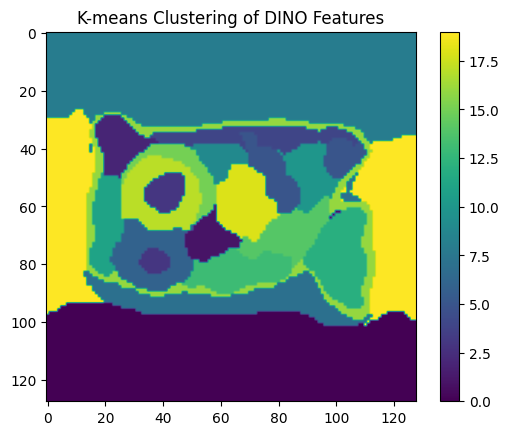

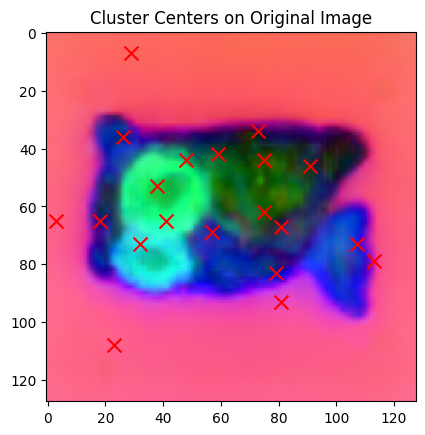

In [3]:
from sklearn.cluster import KMeans
n_clusters = 20

# create clone to avoid in-place operation
target_img_features_flatten = target_img_features.clone()
target_img_features_flatten = target_img_features_flatten.view(-1, target_img_features_flatten.shape[-1])
# target_img_features_flatten /= torch.norm(target_img_features_flatten, dim=-1, keepdim=True)

# apply PCA and colormap
target_img_features_pca = apply_pca_colormap(target_img_features).cpu().numpy() # in_sz, in_sz, 3  
target_img_features_pca_flatten = np.reshape(target_img_features_pca, [-1, target_img_features_pca.shape[-1]]) #  in_sz*in_sz, 3

# cluster the image features
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(target_img_features_flatten.cpu().numpy())
cluster_labels = kmeans.labels_  # Shape: (in_sz*in_sz,)
cluster_centers = kmeans.cluster_centers_  # Shape: (n_cluster, 384)
cluster_labels_2d = cluster_labels.reshape(in_sz, in_sz)

# Display the cluster labels as an image
plt.imshow(cluster_labels_2d, cmap='viridis')  # You can use any colormap you like
plt.colorbar()
plt.title("K-means Clustering of DINO Features")
plt.show()

# Compute the distance from each pixel to each cluster center
distances_to_centers = np.linalg.norm(target_img_features_flatten.cpu().numpy()[:, np.newaxis] - cluster_centers, axis=2)

# Find the pixel closest to each center
closest_pixels = np.argmin(distances_to_centers, axis=0)  # Shape: (k,)

# Convert the flattened indices back to 2D coordinates
closest_pixel_coords = np.unravel_index(closest_pixels, (in_sz, in_sz))  # Shape: (2, k)

# Display the original image
plt.imshow(target_img_features_pca)  # Assuming original_image is grayscale, otherwise remove cmap
plt.scatter(closest_pixel_coords[1], closest_pixel_coords[0], c='red', s=100, marker='x')  # 'x' marks for centers
plt.title("Cluster Centers on Original Image")
plt.show()


#TODO get rid the bg cluster center, does provide information
#TODO make this like interest region sampling strategy

check the distribution

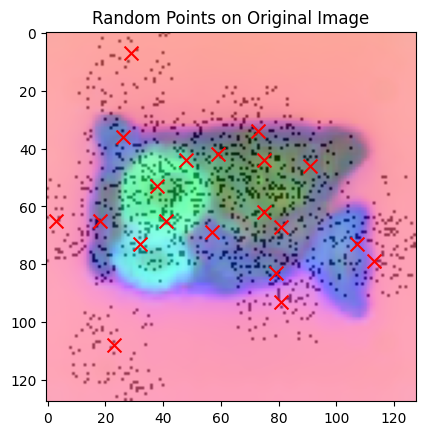

In [4]:
def random_pts_around_centers(closest_pixel_coords, num_points, pt_range):
    random_points = []
    n_clusters = len(closest_pixel_coords[0])
    for i in range(n_clusters):
        # Get the coordinates
        x = closest_pixel_coords[0][i]
        y = closest_pixel_coords[1][i]

        # Generate random points around the given coordinates
        random_points_x = np.random.randint(x - pt_range, x + pt_range, num_points)
        random_points_y = np.random.randint(y - pt_range, y + pt_range, num_points)

        # Append the randomly selected points to the list
        for j in range(num_points):
            random_points.append((random_points_x[j], random_points_y[j]))
    return random_points

random_points = random_pts_around_centers(closest_pixel_coords, num_points=60, pt_range=15)
# Create a 128x128 grid
grid = [[0 for _ in range(128)] for _ in range(128)]

# Mark the generated points on the grid
for point in random_points:
    x, y = point
    grid[x][y] = 1

# Plot the grid
plt.imshow(grid, cmap='binary')
plt.imshow(target_img_features_pca, cmap='gray', alpha=0.6) # apply alpha to make the grid points visible 
plt.scatter(closest_pixel_coords[1], closest_pixel_coords[0], c='red', s=100, marker='x')  # 'x' marks for centers
plt.title("Random Points on Original Image")

plt.show()

#TODO get rid of the points in the bg

### rendering mesh and comparing with VLAD to get a good Initialization

In [7]:
mesh_path = ''
mesh = o3d.io.read_triangle_mesh(mesh_path)
mesh.compute_vertex_normals()
import open3d.visualization.rendering as rendering 

def mesh_render(mesh, img_width, img_height,extrinsic_mat):
    render = rendering.OffscreenRenderer(img_width, img_height)
    # pinhole_camera = o3d.camera.PinholeCameraIntrinsic(img_width, img_height, 150,150, img_width // 2, img_height // 2)
    render.scene.set_background([0, 0, 0, 0])
    material = rendering.MaterialRecord()
    render.scene.add_geometry('mesh', mesh, material)
    # render.scene.set_lighting(rendering.SunLight(intensity=5.0, azimuth=0, elevation=45))
    # render.setup_camera(pinhole_camera,extrinsic_mat)
    # render.setup_camera(60.0, [0, 0, 0], [0, 0, 2.0], [0, 0, 1]) # center: to look at, eye: camera position, up: camera up direction
    render.setup_camera(20.0, [0, 0, 0], extrinsic_mat[:3,3], [0, 0, 1]) # center: to look at, eye: camera position, up: camera up direction
    img_o3d = render.render_to_image()
    return img_o3d

def generate_circle_extrinsics(radius, num_views):
    extrinsics = []
    for i in range(num_views):
        theta = 2 * np.pi * i / num_views
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        z = 1.8

        extrinsic = np.eye(4)
        extrinsic[:3, 3] = [x, y, z]
        # pointing to the center
        direction = -np.array([x, y, z])
        direction /= np.linalg.norm(direction)
        up = np.array([0, 0, 1])
        right = np.cross(up, direction)
        right /= np.linalg.norm(right)
        up = np.cross(direction, right)
        extrinsic[:3, :3] = np.vstack([right, up, direction])
        extrinsics.append(extrinsic)
    return extrinsics


# def Rz(theta):
#     return np.array([
#         [np.cos(theta), -np.sin(theta), 0],
#         [np.sin(theta), np.cos(theta), 0],
#         [0, 0, 1]
#     ])

# extrinsic_matrix = np.eye(4)
# extrinsic_matrix[:3, 3] = np.array([0,0,1.8])
# extrinsic_matrix[:3, :3] = np.array([[0,0,-1],
#                                      [1,0,0],
#                                      [0,-1,0]])

# img_o3d = mesh_render(mesh, 256, 256, extrinsic_matrix)
# plt.imshow(np.asarray(img_o3d))
# plt.show()

extrinsics = generate_circle_extrinsics(5, 20)

image_paths = []

for idx, extrinsic in enumerate(extrinsics):

    img_o3d = mesh_render(mesh, 256, 256, extrinsic)
    # images.append(np.asarray(img_o3d))
    fpath = f'./exp/neus/{obj_name}/meshes/{obj_name}_render_view_{idx}.png'
    o3d.io.write_image(fpath, img_o3d)
    image_paths.append(fpath)

    # visualize
    # plt.imshow(np.asarray(img_o3d))
    # plt.show()



[Open3D WARNING] Read geometry::TriangleMesh failed: unknown file extension.
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version


FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)


libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version


EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.


libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f94550f2e0 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI2: failed to authenticate


Compare cos similarity directly and relative graph

In [8]:
# compare the directly cos similarity   
scores = []
img_features = extract_dino_features(image_paths,device) 

for img_feature in img_features:
    score = torch.dot(img_feature.flatten(), target_img_features.flatten())
    scores.append(score)    

Using cache found in /home/stud/zanr/.cache/torch/hub/facebookresearch_dino_main


Loaded DINO model dino_vits8
Preprocessed 20 images to shape torch.Size([20, 3, 224, 224])


Extracting DINO features: 100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


Extracted DINO embeddings of shape torch.Size([20, 55, 55, 384])


RuntimeError: inconsistent tensor size, expected tensor [1161600] and src [6291456] to have the same number of elements, but got 1161600 and 6291456 elements respectively

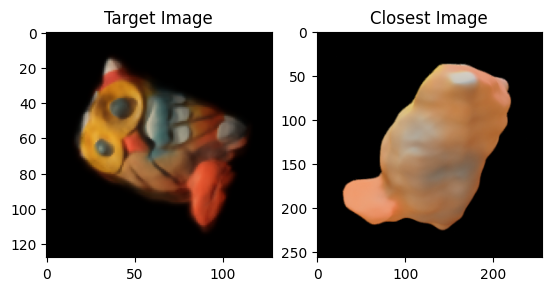

In [ ]:
min_idx = torch.argmin(torch.FloatTensor(scores))
plt.subplot(1, 2, 1)
plt.imshow(target_img[...,[2,1,0]].cpu())
plt.title("Target Image")
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(image_paths[min_idx])[...,[2,1,0]])
plt.title("Closest Image")
plt.show()

# Training

In [5]:
# numpy to tensor
if type(target_img) != torch.Tensor:
    target_img = torch.from_numpy(target_img).float().to(device)
    input_img = torch.from_numpy(input_img).float().to(device)

#TODO should this part removed to before?
target_img = target_img.permute(2, 0, 1) # HWC to CHW
input_img = input_img.permute(2, 0, 1) # HWC to CHW
target_img = T.Resize(in_sz)(target_img)
input_img = T.Resize(in_sz)(input_img)

target_img = target_img.permute(1, 2, 0) 
input_img = input_img.permute(1, 2, 0) # CHW to HWC

# flatten the image
target_img_flatten =torch.reshape(target_img, [-1, 3])  # (H*W, 3)
# target_img_features_flatten = torch.reshape(target_img_features_expanded[0], [-1, 384])
# target_img_features_pca = apply_pca_colormap(target_img_features_expanded[0])
# target_img_features_pca_flatten = torch.reshape(target_img_features_pca, [-1, 3])
# target_img_features_flatten = target_img_features_flatten / torch.norm(target_img_features_flatten, dim=1, keepdim=True) # 128x128, 384
# del target_img_features_expanded


# -------------------- Apply Noise----------------------#

# 1. apply random se3 noise (skipped)


# 2.load pre-defined noisy poses (already rendered)
input_poses = np.load('./outputs/pose1_noised/noisy_poses_1.npy')
input_pose = torch.from_numpy(input_poses[0]) # 3,4 not working, bc only optimize orientation??
input_pose_r6d = Lie().SE3_to_se3(input_pose[:3,:]).unsqueeze(0)
input_pose_t = input_pose[:3,3]
print(f'input pose: {input_pose.shape}')
print(f'input pose r6d: {input_pose_r6d.shape}')

# cam_pose = torch.clone(input_pose.detach()).unsqueeze(0) # batch_sz, 3, 4
cam_r6d = torch.clone(input_pose_r6d.detach())
cam_r6d.requires_grad = True
print(f"Init pose: \n{cam_r6d[0]}")


# -------------------Optimization----------------------#

# Create optimizer. 
opt_configs = {
    'optimizer': 'adam',
    'focal':60, # TODO how to get this value???
    'lr': 1e-2,
    'n_rays': 512,
    'n_steps': 101,
    'sampling': 'cluster_center',
    'with_feature': True,
    'feat_loss_type': 'cos', # 'cos' or 'mse'

}

# apply optimizer configs
lrate = opt_configs['lr']
optimizer = torch.optim.Adam(params=[cam_r6d], lr=lrate)
n_steps = opt_configs['n_steps']

n_rays = opt_configs['n_rays']
sampling = opt_configs['sampling']
with_feature = opt_configs['with_feature']

W, H = target_img.shape[1], target_img.shape[0]
z_near, z_far = 0.2, 3 # line 308 in dataset_mvdiff.py
focal = torch.tensor(opt_configs['focal'], dtype=torch.float32, device=device)

# Loss.
mse_loss = torch.nn.MSELoss()
cos_loss = torch.nn.CosineSimilarity()

# Pose optimization.
predicted_poses = []
fine_patches = []
gt_patches = []
features_patches = []
features_gt_patches = []

for i_step in range(n_steps):
    # update learning rate
    new_lr = lrate * (0.1 ** (i_step // 100))
    optimizer.param_groups[0]['lr'] = new_lr    

    # r6d to rotation matrix
    cam_pose = torch.eye(4)
    cam_pose[:3,:3] = (Lie().se3_to_SE3(cam_r6d))[:,:3,:3]
    cam_pose[:3,3] = input_pose_t 
    cam_pose = torch.unsqueeze(cam_pose,0)

    # generate rays
    # render_rays = gen_rays(cam_pose, W, H, focal, z_near, z_far)
    rays = gen_rays_from_a_view(cam_pose, W, H)
    # render_rays = prepare_rays_a_view(target_img)
    rays_flatten = rays.view(-1, rays.shape[-1])
    assert rays_flatten.shape[0] == H*W
    
    # Sample rays.
    if sampling == 'random':
        idxs_sampled = torch.randint(0, H*W, (n_rays,))
    elif sampling == 'center':
        # take the area between 0.25-0.75 W and H
        frac = 0.5
        mask = torch.zeros((H, W))
        h_low = int(0.5*(1-frac)*H)
        h_high = int(0.5*(1+frac)*H)
        w_low = int(0.5*(1-frac)*W)
        w_high = int(0.5*(1+frac)*W)
        mask[h_low:h_high, w_low:w_high] = 1
        mask = mask.reshape(H*W)

        # sample n_rays in this area for computing error
        idxs_masked = torch.where(mask>0)[0]
        idxs_sampled = idxs_masked[torch.randint(0, idxs_masked.shape[0], (n_rays,))]
    elif sampling == 'obj':
        # sample points within object mask
        obj_mask = obj_mask.reshape(H*W)
        idxs_masked = torch.where(obj_mask>0)[0]
        idxs_sampled = idxs_masked[torch.randint(0, idxs_masked.shape[0], (n_rays,))]
    elif sampling == 'interest_points':
        if POI.shape[0] >= n_rays:
                rand_inds = np.random.choice(POI.shape[0], size=n_rays, replace=False)
                batch = POI[rand_inds]
                idxs_sampled = flatten_position(batch[:, 0], batch[:, 1], W)
                # print(f'sampled idxs: {idxs_sampled.shape}, {idxs_sampled}')
        else:
            batch = np.zeros((n_rays, 2), dtype=int)
            batch[:POI.shape[0]] = POI
            rand_inds = np.random.choice(not_POI.shape[0], size=n_rays-POI.shape[0], replace=False)
            batch[POI.shape[0]:] = not_POI[rand_inds]
            idxs_sampled = flatten_position(batch[:, 0], batch[:, 1], W)
    elif sampling == 'interest_regions':
        rand_inds = np.random.choice(interest_regions.shape[0], size=n_rays, replace=False)
        batch = interest_regions[rand_inds]
        idxs_sampled = flatten_position(batch[:, 0], batch[:, 1], W)
    elif sampling == 'patch':
        frac = 0.25
        mask = torch.zeros((H, W))
        h_low = int(0.5*(1-frac)*H)
        h_high = int(0.5*(1+frac)*H)
        w_low = int(0.5*(1-frac)*W)
        w_high = int(0.5*(1+frac)*W)
        mask[h_low:h_high, w_low:w_high] = 1
        mask = mask.reshape(H*W)

        idxs_sampled = torch.where(mask>0)[0]
    elif sampling == 'cluster_center':
        mask = torch.zeros((H, W))
        random_points = random_pts_around_centers(closest_pixel_coords, num_points=50, pt_range=15)
        # random_points = random_pts_around_centers(closest_pixel_coords, num_points=50, pt_range=15)

        for point in random_points:
            x, y = point
            mask[x, y] = 1
            idxs_sampled = torch.where(mask>0)[0] 
        if(len(random_points) < n_rays):
            n_random_select = n_rays - idxs_sampled.shape[0]
            # print(f' total nrays {n_rays}, sampling extra {n_random_select} rays randomly')
            idxs_sampled_ = torch.randint(0, H*W, (n_random_select,))
            idxs_sampled = torch.cat([idxs_sampled, idxs_sampled_], dim=0)


    # sample some rays
    rays_sampled = rays_flatten[idxs_sampled].to(device=device)

    # render rgb/ features
    render_out = renderer.render(
                                rays_sampled[:, 0:3], 
                                rays_sampled[:, 3:6], 
                                z_near, 
                                z_far, 
                                cos_anneal_ratio=get_cos_anneal_ratio(i_step), 
                                background_rgb=None
                                )

    rgb = render_out['color_fine']
    if with_feature:
        feature = render_out['feature'] # n_rays, 384
        # feature_pca = apply_pca_colormap(feature)
        # feature_norm = torch.norm(feature, dim=-1, keepdim=True)
        # feature_normalized = feature / feature_norm

        #TODO hot fix
        feature_normalized = feature 

    rgb_loss = mse_loss(rgb, target_img_flatten[idxs_sampled]) # range (0,1)
    # feature_loss = mse_loss(feature, target_img_features_flatten[idxs_sampled]) 
    # feature_pca_loss = mse_loss(feature_pca, target_img_features_pca_flatten[idxs_sampled])
    
    if with_feature:
        if opt_configs['feat_loss_type'] == 'cos':
            feature_loss = -cos_loss(feature_normalized, target_img_features_flatten[idxs_sampled])
            feature_loss = torch.mean(feature_loss)
        else:
            feature_loss = mse_loss(feature_normalized, target_img_features_flatten[idxs_sampled])

    optimizer.zero_grad()

    if with_feature:
        loss = feature_loss

        # apply PCA to rendered and gt features together
        all_features = torch.concat([feature_normalized, target_img_features_flatten[idxs_sampled]], dim=0)
        all_features_pca = apply_pca_colormap(all_features)

    else:
        loss = rgb_loss + feature_loss
    loss.backward()

    if i_step % 10 == 0:        
        predicted_poses.append(torch.clone(cam_pose[0]).detach().numpy())

        # image
        fine_patches.append(torch.clone(rgb).detach().cpu().numpy())
        gt_patches.append(torch.clone(target_img_flatten[idxs_sampled]).detach().cpu().numpy())
        
        # features after PCA
        features_patches.append(torch.clone(all_features_pca[:feature.shape[0]]).detach().cpu().numpy())
        features_gt_patches.append(torch.clone(all_features_pca[feature.shape[0]:]).detach().cpu().numpy())
        # print(f' shape of features after PCA: {all_features_pca.shape}')

        # show_distribution(feature_normalized,'feature_normalized')
        # show_distribution(target_img_features_flatten[idxs_sampled], 'feature_gt')

        # print(f"Step {i_step}, loss: {rgb_loss}, error R: {error_R}, error t: {error_t}")
        # print(f"Step {i_step}, rgb loss: {rgb_loss}, feature loss: {feature_loss}, feature_pca_loss: {feature_pca_loss}")   
        print(f"Step {i_step}, loss: {loss}, rgb loss: {rgb_loss}, feature loss: {feature_loss}")   
        
    optimizer.step()

    # why cosine loss close to 0??

input pose: torch.Size([4, 4])
input pose r6d: torch.Size([1, 6])
Init pose: 
tensor([-1.3167,  0.3403,  0.2044, -0.1281, -0.7070, -0.9439],
       grad_fn=<SelectBackward0>)


/home/stud/zanr/software/miniforget3/envs/wonder3d/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Step 0, loss: 0.03513310104608536, rgb loss: 2.730967100241465e-16, feature loss: 0.03513310104608536
Step 10, loss: 0.024119585752487183, rgb loss: 3.878979441017188e-17, feature loss: 0.024119585752487183
Step 20, loss: 0.02010962925851345, rgb loss: 9.995569458390756e-18, feature loss: 0.02010962925851345
Step 30, loss: 0.015899820253252983, rgb loss: 2.2867277753081973e-18, feature loss: 0.015899820253252983
Step 40, loss: 0.012578326277434826, rgb loss: 3.9224214468440973e-19, feature loss: 0.012578326277434826
Step 50, loss: 0.008736028335988522, rgb loss: 3.696791972769376e-20, feature loss: 0.008736028335988522
Step 60, loss: 0.007417311426252127, rgb loss: 8.885713080538138e-21, feature loss: 0.007417311426252127
Step 70, loss: 0.00822317972779274, rgb loss: 5.37258291107488e-21, feature loss: 0.00822317972779274
Step 80, loss: 0.008611238561570644, rgb loss: 4.966433999137076e-21, feature loss: 0.008611238561570644
Step 90, loss: 0.01039342675358057, rgb loss: 5.4471402378201

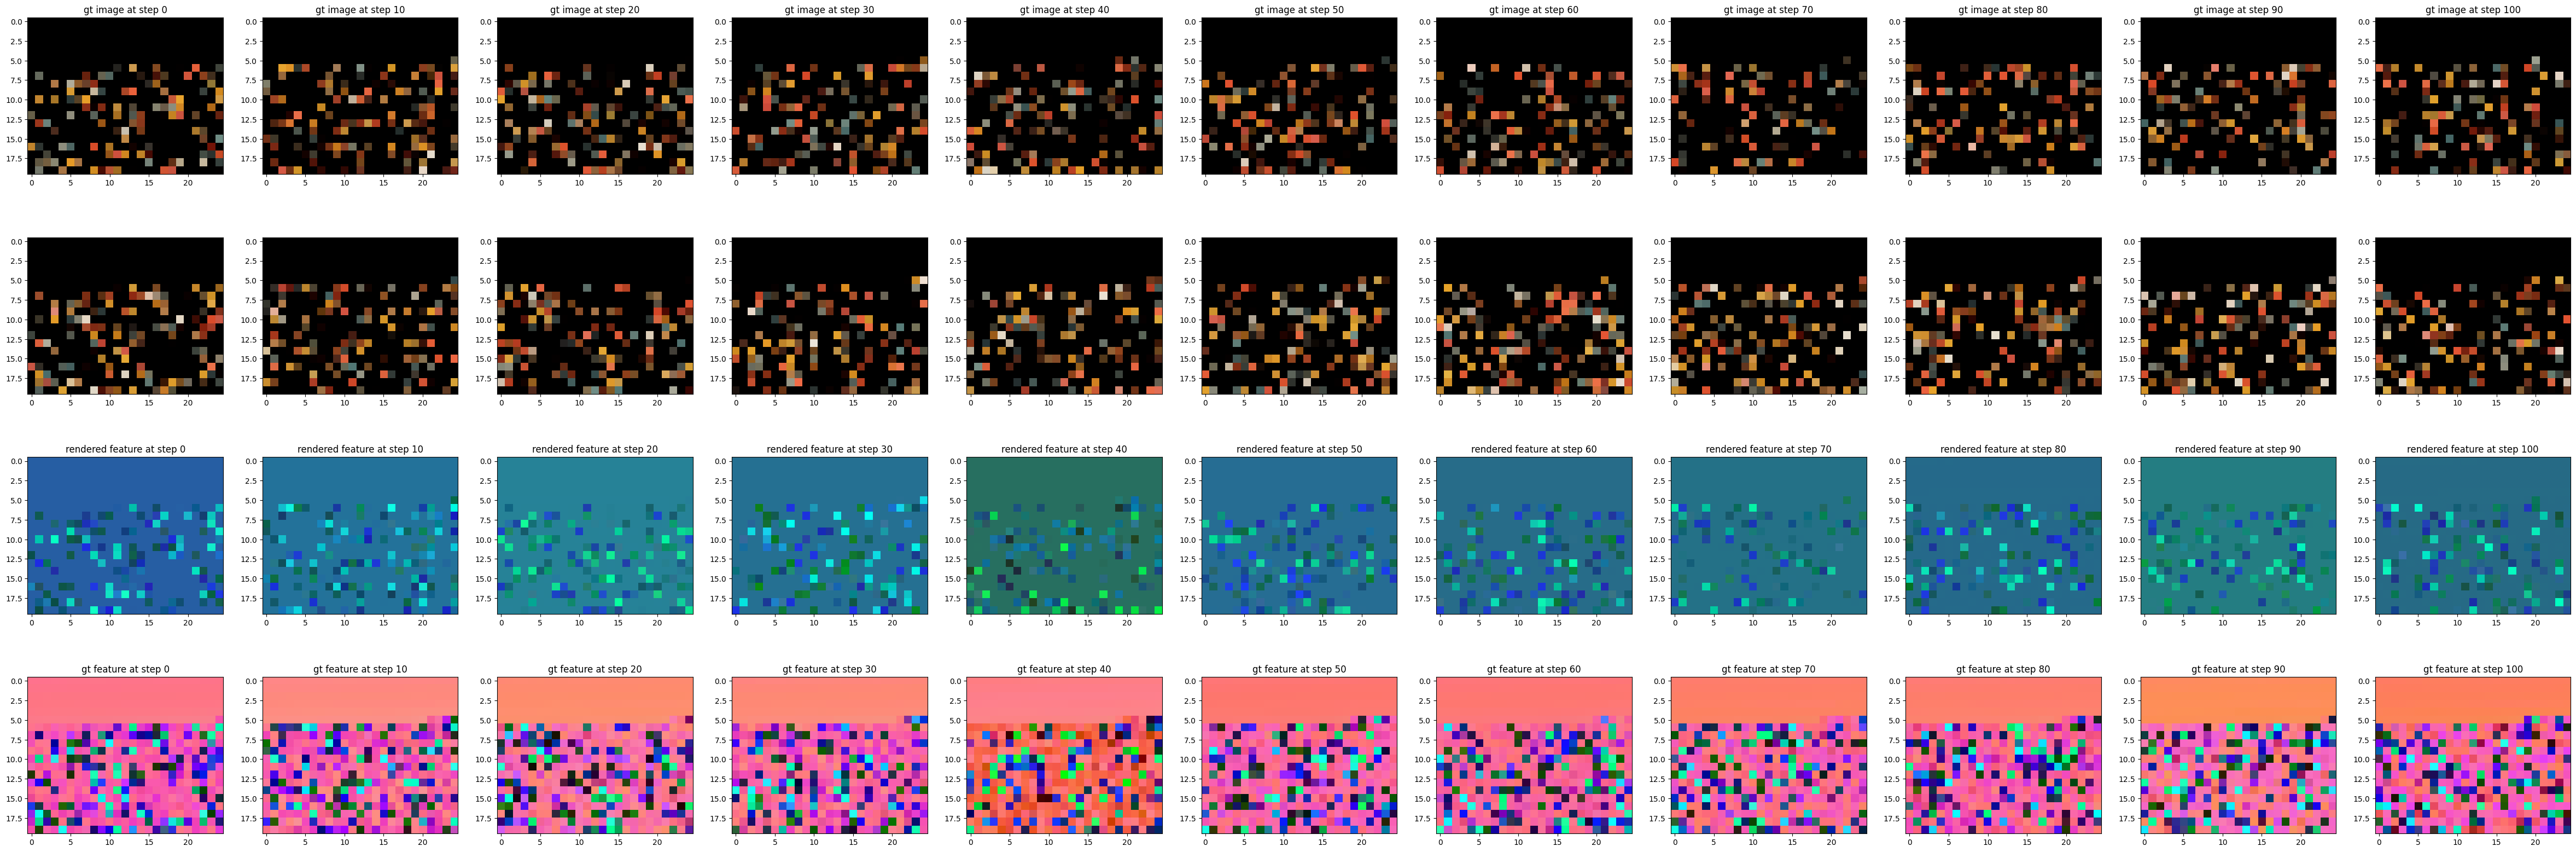

In [90]:
#TODO improve the sampling to have more points in the object

# plot rendered images
fig, axs = plt.subplots(4, len(features_patches))
fig.set_size_inches(60, 20)
for idx in range(len(fine_patches)):
    img_patch_render = fine_patches[idx][:500,:].reshape(20,25,3)
    img_patch_gt = gt_patches[idx][:500,:].reshape(20,25,3)

    features_patch_render = features_patches[idx][:500,:].reshape(20,25,3)
    features_patch_gt = features_gt_patches[idx][:500,:].reshape(20,25,3)

    axs[0, idx].imshow(img_patch_render[..., [2,1,0]])
    axs[0, idx].set_title(f"rendered image at step {idx*10}")
    axs[1, idx].imshow(img_patch_gt[..., [2,1,0]])
    axs[1, idx].set_title(f"gt image at step {idx*10}")


    axs[2, idx].imshow(features_patch_render)
    axs[2, idx].set_title(f"rendered feature at step {idx*10}")

    axs[3, idx].imshow(features_patch_gt)
    axs[3, idx].set_title(f"gt feature at step {idx*10}")

plt.show()

#! fix the rendered feature, color not right???
# plt.figure()
# plt.imshow(features_patch_render - features_patch_gt)
# plt.show()

Distribution of None: max: 1.0, min: 0.0021651899442076683 
 mean: 0.3623770475387573, std: 0.2530324161052704

Distribution of None: max: 1.0, min: 0.0 
 mean: 0.4623560309410095, std: 0.30888864398002625



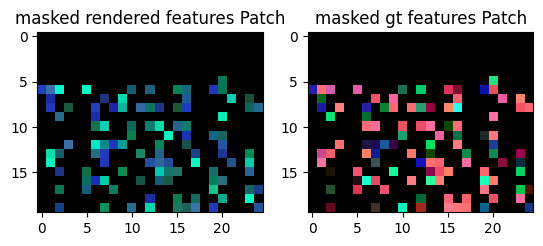

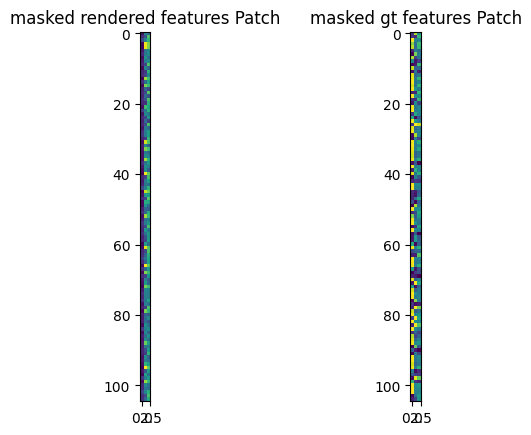

In [91]:
# show the distribution of the features
mask = np.ones(img_patch_render.shape[:2], dtype=np.uint8)
mask[np.all(img_patch_render < 0.01, axis=-1)] = 0

# # Visualize the generated mask
# plt.imshow(mask, cmap='gray')
# plt.title("Generated Mask")
# plt.show()

features_patch_render = cv2.bitwise_and(features_patch_render, features_patch_render, mask=mask)
features_patch_gt = cv2.bitwise_and(features_patch_gt, features_patch_gt, mask=mask)
plt.figure(0)
plt.subplot(1, 2, 1)
plt.imshow(features_patch_render)
plt.title("masked rendered features Patch")
plt.subplot(1, 2, 2)
plt.imshow(features_patch_gt)
plt.title("masked gt features Patch")

# apply mask to the images
features_patch_render_reduced = features_patch_render[mask != 0]
features_patch_gt_reduced = features_patch_gt[mask != 0]
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(features_patch_render_reduced)
plt.title("masked rendered features Patch")
plt.subplot(1, 2, 2)
plt.imshow(features_patch_gt_reduced)
plt.title("masked gt features Patch")


show_distribution(features_patch_render_reduced)
show_distribution(features_patch_gt_reduced)

### Test different sampling strategies

In [6]:
if type(target_img) != torch.Tensor:
    target_img = torch.from_numpy(target_img).float().to(device)
    input_img = torch.from_numpy(input_img).float().to(device)
in_sz = 128

target_img = target_img.permute(2, 0, 1) # HWC to CHW
input_img = input_img.permute(2, 0, 1) # HWC to CHW
target_img = T.Resize(in_sz)(target_img)
input_img = T.Resize(in_sz)(input_img)

target_img = target_img.permute(1, 2, 0) 
input_img = input_img.permute(1, 2, 0) # CHW to HWC

# flatten the image
target_img_flatten =torch.reshape(target_img, [-1, 3])  # (H*W, 3)
target_img_features_flatten = torch.reshape(target_img_features_expanded[0], [-1, 384])  
print(f'target features flatten shape {target_img_features_flatten.shape}')

images_to_save = []
errors_to_save = []
input_poses = np.load('noisy_poses_0.npy')
for i in range(input_poses.shape[0]):
    # initial pose
    input_pose = torch.from_numpy(input_poses[i])
    input_pose_r6d = Lie().SE3_to_se3(input_pose[:3,:3]).unsqueeze(0)
    input_pose_t = input_pose[:3,3]

    sampling_types = ['center', 'interest_points', 'interest_regions']  
    for sampling in sampling_types:
        print(f' current working on pose {i}, with {sampling} sampling')
        # cam_pose = torch.clone(input_pose.detach()).unsqueeze(0) # batch_sz, 3, 4
        cam_r6d = torch.clone(input_pose_r6d.detach())
        cam_r6d.requires_grad = True

        print("Init pose:")
        print(f"{cam_r6d[0]}")


        # Create optimizer. 
        lrate = 1e-2 # TODO chang to args
        optimizer = torch.optim.Adam(params=[cam_r6d], lr=lrate)
        n_steps = 100 + 1

        # z_near, z_far = args.z_near, args.z_far
        # focal = torch.tensor(args.focal, dtyfpe=torch.float32, device=device)
        W, H = target_img.shape[1], target_img.shape[0]
        z_near, z_far = 0.2, 3 # line 308 in dataset_mvdiff.py
        focal = torch.tensor(W/2, dtype=torch.float32, device=device)

        # Loss.
        mse_loss = torch.nn.MSELoss()

        # Sampling.
        n_rays = 512

        # Pose optimization.
        predicted_poses = []
        fine_patches = []
        gt_patches = []

        for i_step in range(n_steps):
            # update learning rate
            new_lr = lrate * (0.1 ** (i_step // 100))
            optimizer.param_groups[0]['lr'] = new_lr    

            # r6d to rotation matrix
            cam_pose = torch.eye(4)
            cam_pose[:3,:3] = r6d_to_rotation_matrix(cam_r6d)
            cam_pose[:3,3] = input_pose_t 
            cam_pose = torch.unsqueeze(cam_pose,0)

            # generate rays
            # render_rays = gen_rays(cam_pose, W, H, focal, z_near, z_far)
            rays = gen_rays_from_a_view(cam_pose, W, H)
            # render_rays = prepare_rays_a_view(target_img)
            rays_flatten = rays.view(-1, rays.shape[-1])
            assert rays_flatten.shape[0] == H*W
            
            # Sample rays.
            if sampling == 'random':
                idxs_sampled = torch.randint(0, H*W, (n_rays,))
            elif sampling == 'center':
                # take the area between 0.25-0.75 W and H
                frac = 0.5
                mask = torch.zeros((H, W))
                h_low = int(0.5*(1-frac)*H)
                h_high = int(0.5*(1+frac)*H)
                w_low = int(0.5*(1-frac)*W)
                w_high = int(0.5*(1+frac)*W)
                mask[h_low:h_high, w_low:w_high] = 1
                mask = mask.reshape(H*W)

                # sample n_rays in this area for computing error
                idxs_masked = torch.where(mask>0)[0]
                idxs_sampled = idxs_masked[torch.randint(0, idxs_masked.shape[0], (n_rays,))]
            elif sampling == 'obj':
                # sample points within object mask
                obj_mask = obj_mask.reshape(H*W)
                idxs_masked = torch.where(obj_mask>0)[0]
                idxs_sampled = idxs_masked[torch.randint(0, idxs_masked.shape[0], (n_rays,))]
            elif sampling == 'interest_points':
                if POI.shape[0] >= n_rays:
                        rand_inds = np.random.choice(POI.shape[0], size=n_rays, replace=False)
                        batch = POI[rand_inds]
                        idxs_sampled = flatten_position(batch[:, 0], batch[:, 1], W)
                        # print(f'sampled idxs: {idxs_sampled.shape}, {idxs_sampled}')
                else:
                    batch = np.zeros((n_rays, 2), dtype=int)
                    batch[:POI.shape[0]] = POI
                    rand_inds = np.random.choice(not_POI.shape[0], size=n_rays-POI.shape[0], replace=False)
                    batch[POI.shape[0]:] = not_POI[rand_inds]
                    idxs_sampled = flatten_position(batch[:, 0], batch[:, 1], W)
            elif sampling == 'interest_regions':
                rand_inds = np.random.choice(interest_regions.shape[0], size=n_rays, replace=False)
                batch = interest_regions[rand_inds]
                idxs_sampled = flatten_position(batch[:, 0], batch[:, 1], W)
            elif sampling == 'patch':
                frac = 0.25
                mask = torch.zeros((H, W))
                h_low = int(0.5*(1-frac)*H)
                h_high = int(0.5*(1+frac)*H)
                w_low = int(0.5*(1-frac)*W)
                w_high = int(0.5*(1+frac)*W)
                mask[h_low:h_high, w_low:w_high] = 1
                mask = mask.reshape(H*W)

                idxs_sampled = torch.where(mask>0)[0]

            # sample some rays
            rays_sampled = rays_flatten[idxs_sampled].to(device=device)

            # render rgb/ features
            render_out = renderer.render(
                                        rays_sampled[:, 0:3], 
                                        rays_sampled[:, 3:6], 
                                        z_near, 
                                        z_far, 
                                        cos_anneal_ratio=get_cos_anneal_ratio(i_step), 
                                        background_rgb=None
                                        ) # TODO check get_cos_anneal_ratio(input)

            rgb = render_out['color_fine']
            feature = render_out['feature']
            
            rgb_loss = mse_loss(rgb, target_img_flatten[idxs_sampled])
            feature_loss = mse_loss(feature, target_img_features_flatten[idxs_sampled])  

            optimizer.zero_grad()
            # loss = rgb_loss + feature_loss
            loss = rgb_loss
            # loss = feature_loss
            loss.backward()

            if i_step % 10 == 0:        
                predicted_poses.append(torch.clone(cam_pose[0]).detach().numpy())
                fine_patches.append(torch.clone(rgb).detach().cpu().numpy())
                gt_patches.append(torch.clone(target_img_flatten[idxs_sampled]).detach().cpu().numpy())

                # pose_pred = predicted_poses[-1].copy()
                # pose_pred[2, -1] -= 2.
                # pose_pred = input_pose @ pose_pred
                # error_R, error_t = compute_pose_error(pose_pred, pose_target)
                # print(f"Step {i_step}, loss: {rgb_loss}, error R: {error_R}, error t: {error_t}")
                print(f"Step {i_step}, rgb loss: {rgb_loss}, feature loss: {feature_loss}")
            
            if i_step == n_steps-1:
                images_to_save.append(fine_patches)
                errors_to_save.append(loss)
            optimizer.step()



NameError: name 'target_img_features_expanded' is not defined

In [9]:
len(images_to_save)
for i in range(len(images_to_save)):
    print(f'current pose: {i}')
    for j in range(len(images_to_save[i])):
        img = images_to_save[i][j]
        img = img.reshape(128,128,3)
        img = img*255
        img = img.astype(np.uint8)
        show_img(f'pose {i}, step {j}', img)
        print(f'error: {errors_to_save[i]}')

current pose: 0


ValueError: cannot reshape array of size 1536 into shape (128,128,3)

In [15]:
# save the predicted poses
predicted_poses_save = np.stack(predicted_poses, axis=0)
np.save('predicted_poses.npy', predicted_poses_save)

## Render Results

In [6]:
# Rendering of whole image
overlay_frames = []
features_patches = []
features_patches_gt = []
n_poses = len(predicted_poses)
render_poses = torch.from_numpy(np.array(predicted_poses)).float()
print("render_poses", render_poses.shape)

# render_rays = gen_rays(render_poses, W, H, focal, z_near, z_far)
# print(f'shape of rendered rays from inerf {render_rays.shape}')


# render single view from a predicted pose
for i in range(n_poses):
    render_rays = gen_rays_from_a_view(render_poses[i,None,:,:], W, H)
    render_rays = render_rays.to(device='cuda')

    with torch.no_grad():
        print(f"Rendering {H * W} rays for pose {i}")
        all_rgb_fine = []
        all_features_fine = []
        for rays in tqdm.tqdm(torch.split(render_rays.view(-1, render_rays.shape[-1]), 100, dim=0)):
            render_out = renderer.render(
                rays[..., 0:3], 
                rays[..., 3:6], 
                z_near, 
                z_far, 
                cos_anneal_ratio=get_cos_anneal_ratio(0), 
                background_rgb=None
            )

            rgb = render_out['color_fine']
            feature = render_out['feature']
            all_rgb_fine.append(rgb)
            all_features_fine.append(feature)
        
        rgb_fine = torch.cat(all_rgb_fine)
        features_fine = torch.cat(all_features_fine)

        # feature_fine_normalized = features_fine / torch.norm(features_fine, dim=-1, keepdim=True)

        frame = (rgb_fine.view(H, W, 3).cpu().numpy() * 255).astype(np.uint8)
        overlay_frames.append(frame)

        # show distribution
        # show_distribution(features_fine, 'feature rendered')
        # show_distribution(target_img_features_flatten, 'feature gt')

        # PCA
        all_features = torch.concat([features_fine, target_img_features_flatten], dim=0)
        all_features_pca = apply_pca_colormap(all_features)

        features_patches.append(torch.clone(all_features_pca[:features_fine.shape[0]]).detach().cpu().numpy())
        features_patches_gt.append(torch.clone(all_features_pca[features_fine.shape[0]:]).detach().cpu().numpy())

render_poses torch.Size([11, 4, 4])
Rendering 16384 rays for pose 0


100%|██████████| 164/164 [00:01<00:00, 82.29it/s]


Rendering 16384 rays for pose 1


100%|██████████| 164/164 [00:01<00:00, 82.81it/s]


Rendering 16384 rays for pose 2


100%|██████████| 164/164 [00:01<00:00, 82.82it/s]


Rendering 16384 rays for pose 3


100%|██████████| 164/164 [00:01<00:00, 82.63it/s]


Rendering 16384 rays for pose 4


100%|██████████| 164/164 [00:01<00:00, 82.53it/s]


Rendering 16384 rays for pose 5


100%|██████████| 164/164 [00:01<00:00, 82.59it/s]


Rendering 16384 rays for pose 6


100%|██████████| 164/164 [00:01<00:00, 82.46it/s]


Rendering 16384 rays for pose 7


100%|██████████| 164/164 [00:01<00:00, 82.47it/s]


Rendering 16384 rays for pose 8


100%|██████████| 164/164 [00:01<00:00, 82.26it/s]


Rendering 16384 rays for pose 9


100%|██████████| 164/164 [00:01<00:00, 82.53it/s]


Rendering 16384 rays for pose 10


100%|██████████| 164/164 [00:01<00:00, 82.40it/s]


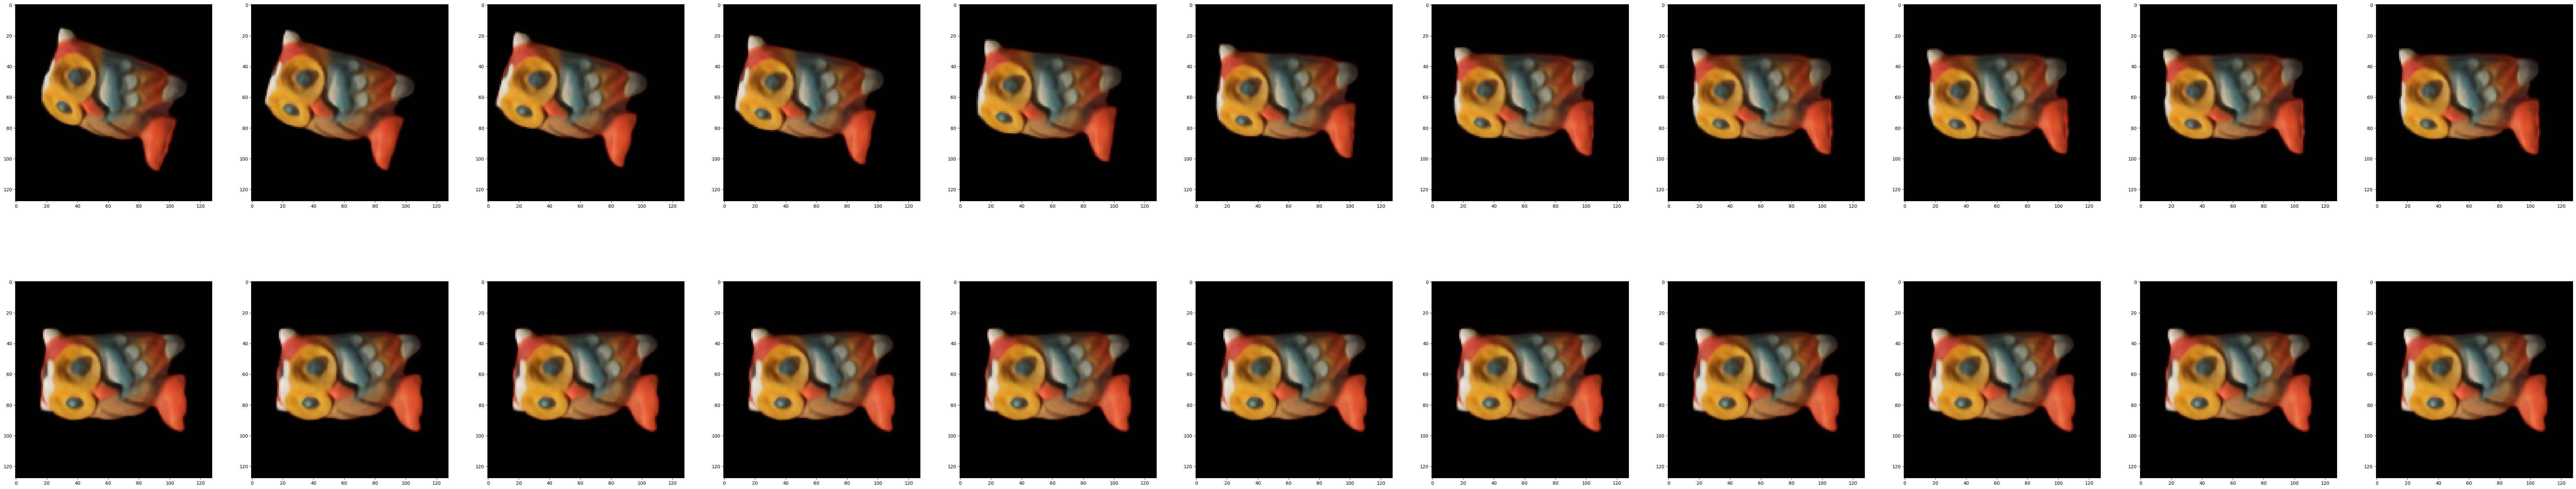

In [7]:
# plot rendered images
target_img_np = (target_img * 255).cpu().numpy().astype(np.uint8)
fig, axs = plt.subplots(2, len(overlay_frames))
fig.set_size_inches(100, 20)
for i in range(len(fine_patches)):
    axs[0, i].imshow(overlay_frames[i][...,[2,1,0]])
    axs[1, i].imshow(target_img_np[...,[2,1,0]])
plt.show()

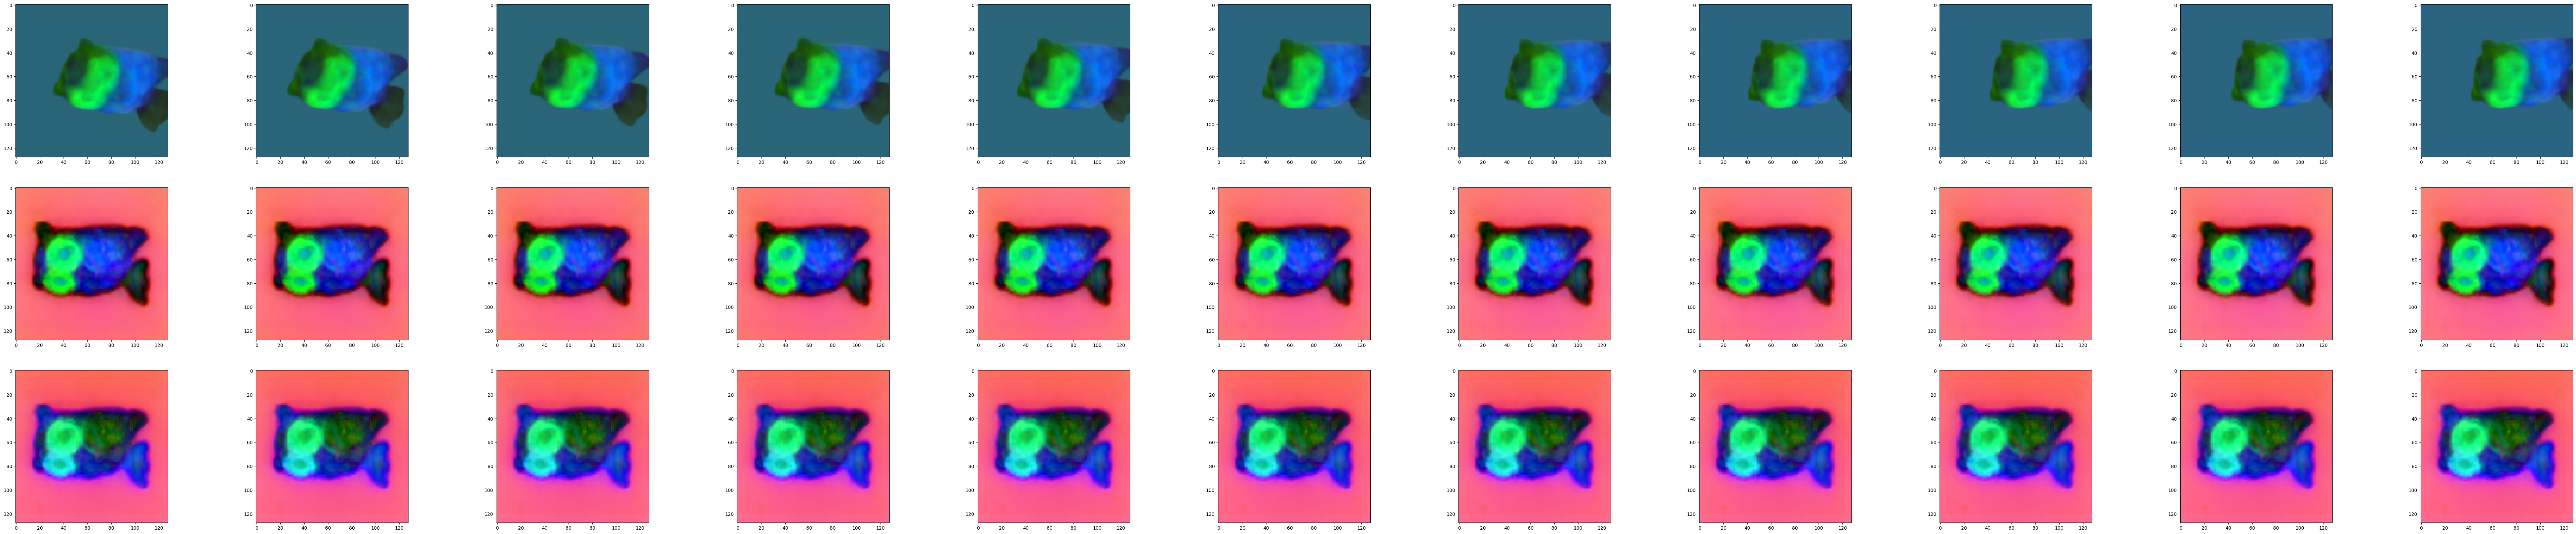

rendered feature 0.014870550483465195
patch feature gt 0.3080163896083832


In [10]:
# render PCA
fig, axs = plt.subplots(3, len(features_patches))
fig.set_size_inches(100, 20)

for i in range(len(features_patches)):
    feat_patch = features_patches[i].reshape(128,128,3)
    feat_patch_gt = features_patches_gt[i].reshape(128,128,3)

    axs[0, i].imshow(feat_patch)
    axs[1, i].imshow(feat_patch_gt)
    axs[2, i].imshow(target_img_features_pca)
plt.show()

print(f'rendered feature {features_fine.std()}')
print(f'patch feature gt {feat_patch_gt.std()}')
# print(f'abs gt feature {target_img_features.std()}')


In [ ]:
# save the predicted poses
predicted_poses_save = np.stack(predicted_poses, axis=0)
np.save('predicted_poses.npy', predicted_poses_save)


# Render Image using NERF

In [58]:
cam_pose_dir = "../instant-nsr-pl/datasets/fixed_poses/"

input_poses = [] 

# do not forget to convert the poses to opencv format and inverse
for poses_fpath in os.listdir(cam_pose_dir):
    pose_tmp = np.loadtxt(os.path.join(cam_pose_dir, poses_fpath))
    input_poses.append(inv_RT(RT_opengl2opencv(pose_tmp)))
    
n_poses = len(input_poses)
print(f"Loaded {len(input_poses)} poses from {cam_pose_dir}")

input_poses_ts = torch.from_numpy(np.array(input_poses)).float()
# H, W = target_img.shape[1], target_img.shape[0]
H, W = in_sz, in_sz 
z_near, z_far = 0.2, 2.4 # line 308 in dataset_mvdiff.py
focal = torch.tensor(W/2, dtype=torch.float32, device=device) # TODO, how to set focal length

# target_img = torch.from_numpy(target_img).float().to(device)
# target_img_flatten =torch.reshape(target_img, [-1, 3]) # normalized

Loaded 9 poses from ../instant-nsr-pl/datasets/fixed_poses/


In [65]:
# render_pose_0 = torch.from_numpy(np.array(predicted_poses[0])).float()

input_pose_batch =input_poses_ts[1].unsqueeze(0).repeat(10, 1, 1)
print(f"input pose batch shape: {input_pose_batch.shape}")
SE3_noise = generate_SE3_noise(input_pose_batch, amplitude=0.2)

noisy_poses = compose_pair(input_pose_batch, SE3_noise)

input pose batch shape: torch.Size([10, 3, 4])


In [79]:
config = {
        'input': '.',
        'output':'./outputs',
        }

# render_poses = input_poses_ts # direct render from input poses
render_poses = noisy_poses

n_poses = render_poses.shape[0]
# render_rays = gen_rays(render_poses, W, H, focal, z_near, z_far)
# print(f'shape of rendered rays from inerf {render_rays.shape}')
render_rays = gen_rays_from_a_view(render_poses, W, H)
print(f'shape of rendered rays from NEUS {render_rays.shape}')
render_rays = render_rays.to(device='cuda')
with torch.no_grad():
    print("Rendering", n_poses * H * W, "rays")
    all_rgb_fine = []
    for rays in tqdm.tqdm(torch.split(render_rays.view(-1, render_rays.shape[-1]), 100, dim=0)):
        render_out = renderer.render(
                                    rays[..., 0:3], 
                                    rays[..., 3:6], 
                                    z_near, 
                                    z_far, 
                                    cos_anneal_ratio=get_cos_anneal_ratio(0), 
                                    background_rgb=None
                                    ) # TODO check get_cos_anneal_ratio(input)

        rgb = render_out['color_fine']
        all_rgb_fine.append(rgb)
    rgb_fine = torch.cat(all_rgb_fine)
    frames = (rgb_fine.view(n_poses, H, W, 3).cpu().numpy() * 255).astype(
        np.uint8
    )

shape of rendered rays from NEUS torch.Size([10, 16384, 6])
Rendering 163840 rays


  0%|          | 0/1639 [00:00<?, ?it/s]

100%|██████████| 1639/1639 [00:19<00:00, 83.54it/s]


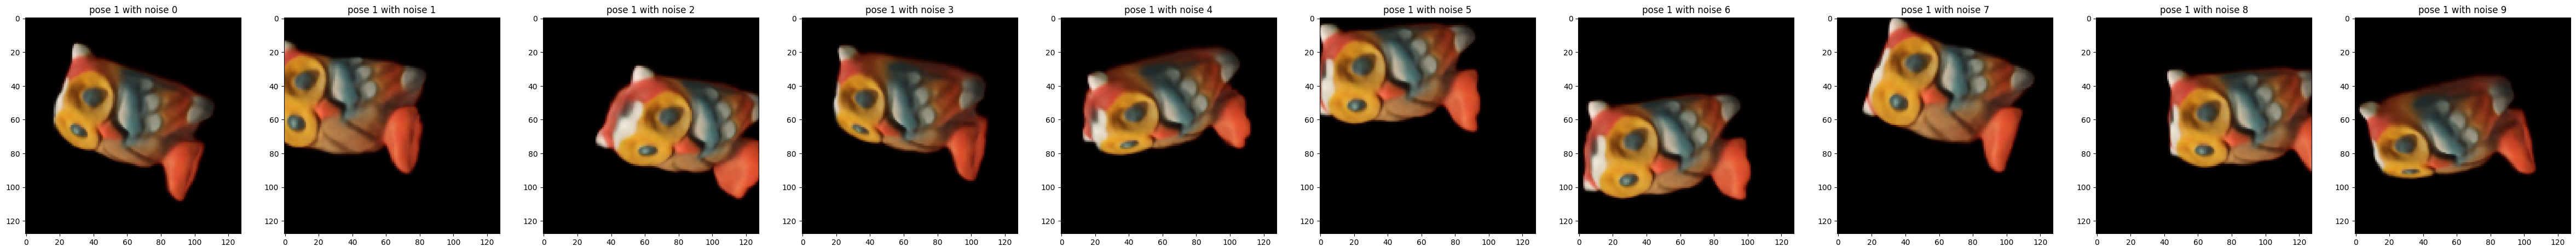

: 

In [81]:
write_figs = True
fig, axs = plt.subplots(1,n_poses)
fig.set_size_inches(60, 20)
for i in range(n_poses):
    axs[i].imshow(frames[i][...,[2,1,0]])
    axs[i].set_title(f'pose 1 with noise {i}')


if write_figs:
    os.makedirs('./outputs/pose1_noised', exist_ok=True)
    for ii in range(frames.shape[0]):
        rendered_img_path = os.path.join('./outputs/pose1_noised', f'noised_{ii}.png')
        cv2.imwrite(rendered_img_path, frames[ii])
    # fig.savefig('noisy_poses.png')

In [69]:
np.save(f'./SE3_noise_{1}.npy', SE3_noise)
np.save(f'./noisy_poses_{1}.npy', noisy_poses)

# Mes

In [ ]:
# for comparsion 
fig, axs = plt.subplots(3,n_poses//3)
fig.set_size_inches(60, 40)
for i in range(n_poses//3):
    axs[0,i].imshow(frames[i][...,[2,1,0]])
    axs[0,i].set_title(f'pose {i}')
    axs[1,i].imshow(frames[i+n_poses//3][...,[2,1,0]])
    axs[1,i].set_title(f'wo conversion')
    axs[2,i].imshow(frames[i+n_poses//3*2][...,[2,1,0]])
    axs[2,i].set_title(f'wo conversion and inv')

fig.tight_layout()
plt.show()
fig.savefig('rendered_images.png')

    # axs[1, i].imshow(target_img_np[...,[2,1,0]])
